## Process data

Load the gea data, taking only the 30 most abundant classes.
Here as a new thing I will take 2048 sequence length so it will be split in $4*512$ preds by the model.

Here training and test data is completely balanced (283 observations per class)

**VERY IMPORTANT:** Here, since I cannot find enough stretches without any "N" nucleotide to get this amount of samples for all classes and the model does not support them, I follow this strategy:
 - Take a random sequence that does not have more than 3 Ns, convert the Ns to A residues.
 - There are many sequences without any Ns but I am afraid that if I do this I would be 

In [1]:
# set directory of this repo so that all paths can be absolute/relative (not ended with a '/')
path_prefix = '/home/mexposit/cg/gea'

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def rev_comp(seq):
    revcomp = ''
    for nt in seq:
        if nt.upper() == 'A':
            revcomp = revcomp+'T'
        elif nt.upper() == 'G':
            revcomp = revcomp+'C'
        elif nt.upper() == 'C':
            revcomp = revcomp+'G'
        elif nt.upper() == 'T':
            revcomp = revcomp+'A'
        else:
            raise ValueError(f'Unrecognized nucleotide {nt}')
    return revcomp[::-1]

In [4]:
rev_comp('ATCG')

'CGAT'

In [5]:
def min_nonN_seq(seq):
    """
    Gets the number of contiguous nucleotides in a sequence that are not N
    """
    seq = seq.upper()
    max_stretch = 0
    cont_len = 0
    for char in seq:
        if char in 'ATCG':
            cont_len += 1
        elif char == 'N':
            # found N, see if contiguous count is larger than previous maximum
            if cont_len > max_stretch:
                max_stretch = cont_len
            # reset to zero
            cont_len = 0
        else:
            raise ValueError(f'Found unrecognized nucleotide {char} in seq {seq}')
    # get stretch if no N has been found
    if max_stretch == 0:
        max_stretch = cont_len
    return max_stretch    

In [6]:
print(min_nonN_seq('ATCGTNATNA'))
print(min_nonN_seq('NNNN'))
print(min_nonN_seq('agtcatc'))

5
0
7


### Load data

In [7]:
train_vals = pd.read_csv(f'{path_prefix}/data/train_values.csv', index_col=0)
train_labl = pd.read_csv(f'{path_prefix}/data/train_labels.csv', index_col=0)

In [8]:
train_vals.head()

,sequence,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,copy_number_low_copy,copy_number_unknown,growth_strain_ccdb_survival,...,species_budding_yeast,species_fly,species_human,species_mouse,species_mustard_weed,species_nematode,species_other,species_rat,species_synthetic,species_zebrafish
sequence_id,,,,,,,,,,,,,,,,,,,,,
9ZIMC,CATGCATTAGTTATTAATAGTAATCAATTACGGGGTCATTAGTTCA...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5SAQC,GCTGGATGGTTTGGGACATGTGCAGCCCCGTCTCTGTATGGAGTGA...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
E7QRO,NNCCGGGCTGTAGCTACACAGGGCGGAGATGAGAGCCCTACGAAAG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
CT5FP,GCGGAGATGAAGAGCCCTACGAAAGCTGAGCCTGCGACTCCCGCAG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7PTD8,CGCGCATTACTTCACATGGTCCTCAAGGGTAACATGAAAGTGATCC...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
train_labl.head()

,00Q4V31T,012VT4JK,028IO5W2,03GRNN7N,03Y3W51H,09MQV1TY,0A4AHRCT,0A9M05NC,0B9GCUVV,0CL7QVG8,...,ZQNGGY33,ZSHS4VJZ,ZT1IP3T6,ZU6860XU,ZU6TVFFU,ZU75P59K,ZUI6TDWV,ZWFD8OHC,ZX06ZDZN,ZZJVE4HO
sequence_id,,,,,,,,,,,,,,,,,,,,,
9ZIMC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5SAQC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E7QRO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CT5FP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7PTD8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### There are sequence duplicates, remove them

Aprox 500 entries

In [10]:
train_vals.shape

(63017, 40)

In [11]:
train_vals.drop_duplicates('sequence', inplace=True)

In [12]:
train_vals.shape

(62643, 40)

Also make the change in the labels

In [13]:
train_labl = train_labl.loc[train_vals.index].copy()

In [14]:
train_vals.shape

(62643, 40)

### Count which labs are more abundant

Reverse one hot encoding of labels

In [15]:
labs = train_labl.columns

In [16]:
labels = train_labl.apply(lambda x: labs[np.array(x.values, dtype=bool)][0], axis=1)

In [17]:
# here we use top 30 most abundant labs
top_n = 30

In [18]:
topn_abundant_labs = labels.value_counts()[:top_n]

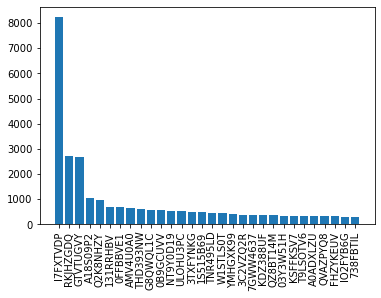

In [19]:
plt.bar(x=topn_abundant_labs.index, height=topn_abundant_labs.values)
plt.xticks(rotation = 90)
plt.show()

How large is the imbalance?

In [20]:
f'Ratio most abundant : less abundant = {topn_abundant_labs[0]}/{topn_abundant_labs[-1]} = {round(topn_abundant_labs[0]/topn_abundant_labs[-1],3)}'

'Ratio most abundant : less abundant = 8226/284 = 28.965'

In [21]:
f'Ratio second most abundant : less abundant = {topn_abundant_labs[1]}/{topn_abundant_labs[-1]} = {round(topn_abundant_labs[1]/topn_abundant_labs[-1],3)}'

'Ratio second most abundant : less abundant = 2732/284 = 9.62'

It is not terribly imbalanced. However, here I am testing multiclass classification, not the effect of imbalance.

**Strategy:** For this test, I will just UNDERSAMPLE the most abundant classes to the number of samples of the least abundant one. I will not sample multiple times from the same plasmid sequence as I have done before, as it was not really necessary at least for binary classification.

### Reduce data to only selected classes undersampling to have them balanced

In [22]:
obs_per_label = topn_abundant_labs[-1]
print(obs_per_label)

284


In [23]:
sele_labs = topn_abundant_labs.index.to_list()
print(sele_labs)

['I7FXTVDP', 'RKJHZGDQ', 'GTVTUGVY', 'A18S09P2', 'Q2K8NHZY', '131RRHBV', '0FFBBVE1', 'AMV4U0A0', 'THD393NW', 'G8QWQL1C', '0B9GCUVV', 'NT9Y0D19', 'ULOHU3PC', '3TXFYNKG', '1S515B69', 'TNR495LD', 'W1STLS0T', 'YMHGXK99', '3C2VZQ2R', '7GWW4637', 'KDZ388UF', 'QZ8BT14M', '03Y3W51H', 'KSFFKSV7', 'T9LSOTV6', 'A0ADXLZU', 'QVAZPYQ8', 'FHZYKEUV', 'IO2FYB6G', '738FBTIL']


In [24]:
## this is used to select all observations with the selected labels
# sele_index = labels[labels.isin(sele_labs)]
# print(sele_index.value_counts()[:10])
# print(sele_index)

In [25]:
sele_index = pd.Series(dtype=str)
for lab in sele_labs:
    idx = labels[labels == lab]
    sele_index = pd.concat([sele_index, idx.sample(n=obs_per_label, replace=False, random_state=42)])

In [26]:
sele_index.value_counts()

I7FXTVDP    284
RKJHZGDQ    284
IO2FYB6G    284
FHZYKEUV    284
QVAZPYQ8    284
A0ADXLZU    284
T9LSOTV6    284
KSFFKSV7    284
03Y3W51H    284
QZ8BT14M    284
KDZ388UF    284
7GWW4637    284
3C2VZQ2R    284
YMHGXK99    284
W1STLS0T    284
TNR495LD    284
1S515B69    284
3TXFYNKG    284
ULOHU3PC    284
NT9Y0D19    284
0B9GCUVV    284
G8QWQL1C    284
THD393NW    284
AMV4U0A0    284
0FFBBVE1    284
131RRHBV    284
Q2K8NHZY    284
A18S09P2    284
GTVTUGVY    284
738FBTIL    284
dtype: int64

In [27]:
# all indices are unique, so we did not include twice the same sequence
sele_index.index.has_duplicates

False

In [28]:
sele_train = train_vals.loc[sele_index.index].copy()

In [29]:
sele_train = sele_train.join(sele_index.rename('label'))
sele_train = sele_train[['sequence','label']]

In [30]:
sele_train.head()

,sequence,label
6RYTD,CCTGCAGGCAGCTGCGCGCTCGCTCGCTCACTGAGGCCGCCCGGGC...,I7FXTVDP
QAXF7,AAAACGCCAGCAACGCGGCCTTTTTACGGTTCCTGGCCTTTTGCTG...,I7FXTVDP
6R9GK,TCGCCCTTGCTTGTGCCGTGGTGATGGTGGTGATGGTGGTGACCAG...,I7FXTVDP
Z33CT,CTAAATTGTAAGCGTTAATATTTTGTTAAAATTCGCGTTAAATTTT...,I7FXTVDP
7TLWX,GCAGCCGGATCTCAGTGGTGGTGGTGGTGGTGCTCGAGTGCGGCCG...,I7FXTVDP


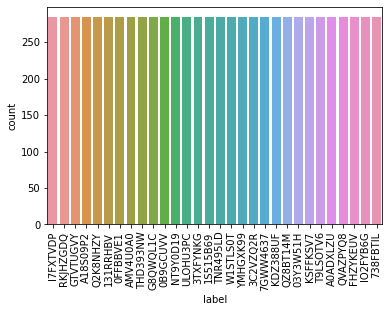

In [31]:
sns.countplot(x=sele_train.label)
plt.xticks(rotation=90)
plt.show()

### Check plasmid length of the subsampled

In [32]:
plasmid_length_sum = []
for lab in sele_labs:
    plasmid_length_sum.append(np.sum([len(seq) for seq in sele_train[sele_train['label'] == lab]['sequence']]))

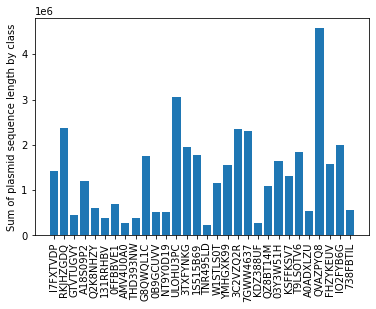

In [33]:
plt.bar(x=sele_labs, height=plasmid_length_sum)
plt.xticks(rotation=90)
plt.ylabel('Sum of plasmid sequence length by class')
plt.show()

The median plasmid length is quite different. Some are quite short

In [34]:
plasmid_length_median = []
for lab in sele_labs:
    plasmid_length_median.append(np.median([len(seq) for seq in sele_train[sele_train['label'] == lab]['sequence']]))

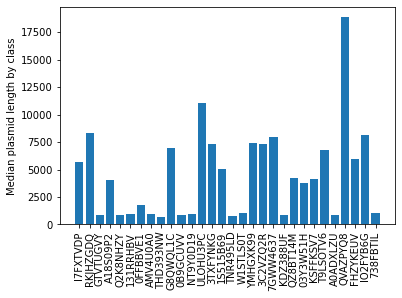

In [35]:
plt.bar(x=sele_labs, height=plasmid_length_median)
plt.xticks(rotation=90)
plt.ylabel('Median plasmid length by class')
plt.show()

The minimum is quite low.

In [36]:
plasmid_length_min = []
for lab in sele_labs:
    plasmid_length_min.append(np.min([len(seq) for seq in sele_train[sele_train['label'] == lab]['sequence']]))

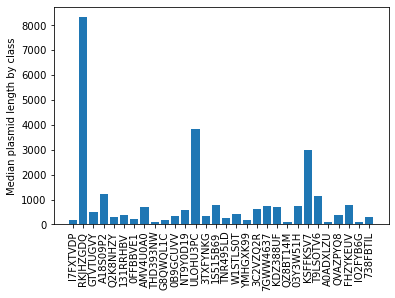

In [37]:
plt.bar(x=sele_labs, height=plasmid_length_min)
plt.xticks(rotation=90)
plt.ylabel('Median plasmid length by class')
plt.show()

There are sequences that are shorter than 100

In [38]:
np.min(plasmid_length_min)

86

### Redo sampling to ensure >100nts length

We can randomly sample from the subset of plasmids above 100nts in length for the classes that are more abundant and see if there are enough.

Alternatives that could also be tried: Concatenating the end of the plasmid with its beggining to get 100nts (since they are circular this can be done) or append the Rev Complement at the end (a winning solution did this)

First, check if all classes have more than `obs_per_label=284` sequences with >100nts and no 'N' (undefined) nucleotides

In [39]:
obs_per_label = topn_abundant_labs[-1]
print(obs_per_label)

284


In [40]:
obs_per_label = 281

In [41]:
train_vals['seq_len'] = [len(seq) for seq in train_vals['sequence']]

In [42]:
# get the maximum length of contiguous sequence without any undefined nucleotide
train_vals['min_nonN_seq'] = [min_nonN_seq(seq) for seq in train_vals['sequence']]

In [43]:
# number of N per sequence
train_vals['undefval'] = [seq.upper().count('N') for seq in train_vals['sequence']]

In [44]:
train_vals['label'] = labels

In [46]:
min_len = 2048 # thld to accept sequences

labels_more_detail = []
for lab in sele_labs:
    subset = train_vals[(train_vals['label'] == lab)].copy()
    if np.sum(subset['min_nonN_seq'] > min_len) > obs_per_label:
        print(f'label {lab} is ok')
    else:
        labels_more_detail.append(lab)

label I7FXTVDP is ok
label RKJHZGDQ is ok
label GTVTUGVY is ok
label A18S09P2 is ok
label 0FFBBVE1 is ok
label G8QWQL1C is ok
label ULOHU3PC is ok
label 3TXFYNKG is ok
label 1S515B69 is ok
label YMHGXK99 is ok
label 3C2VZQ2R is ok
label 7GWW4637 is ok
label KSFFKSV7 is ok
label T9LSOTV6 is ok
label QVAZPYQ8 is ok
label FHZYKEUV is ok


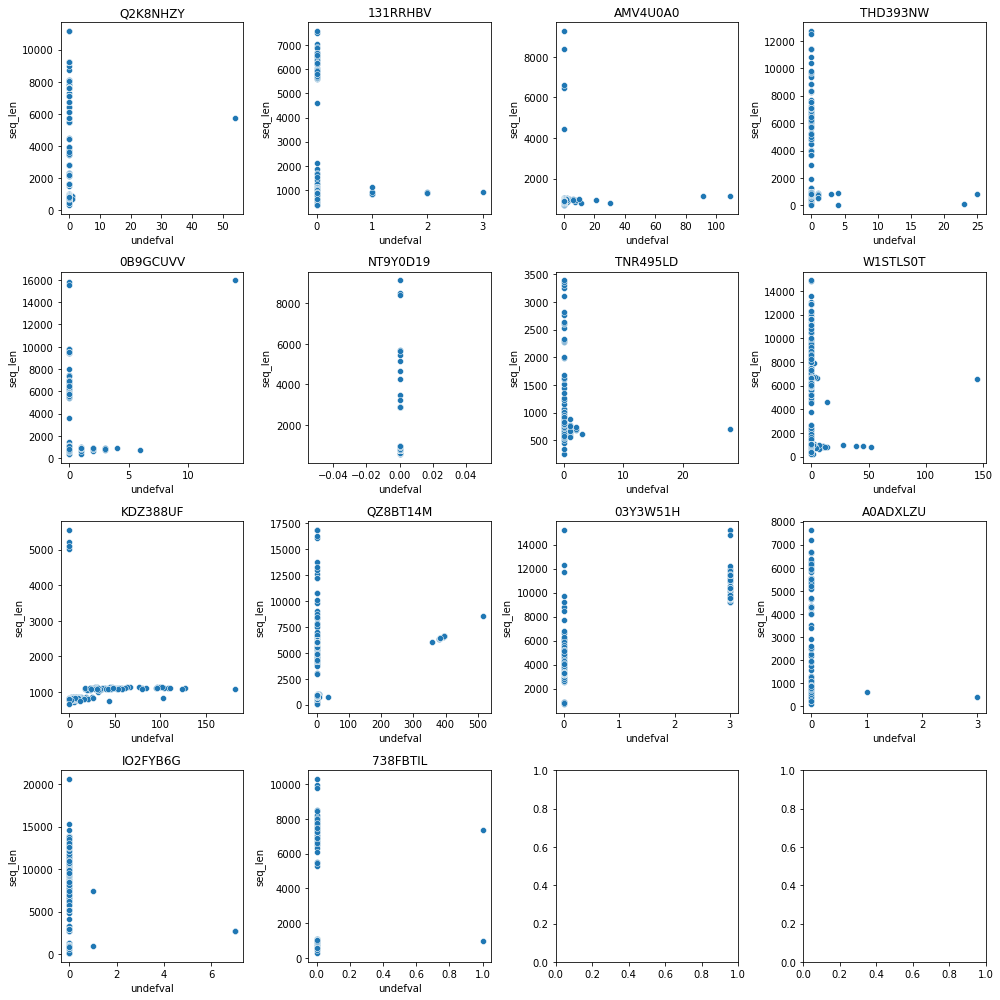

In [47]:
fig, axs = plt.subplots(4,4, figsize=(14,14))
axs = axs.flatten()
for i, lab in enumerate(labels_more_detail):
    sns.scatterplot(x='undefval', y='seq_len', data=train_vals[(train_vals['label'] == lab)], ax=axs[i])
    axs[i].set_title(lab)
plt.tight_layout()

From what I see above, a good strategy is:
 - Samples that have enough samples, subsample sequences of 2048 avoiding N.
 - If they don't have enough samples:
     - Discard all the ones that have more than 10 N undefined residues
     - Subsample the required number of sequences using weights corresponding to sequence length, so that longer sequences are picked up more often, and they will be padded by the model

In [48]:
obs_per_label = 281
min_len = 2048

In [49]:
sele_train = []
for lab in sele_labs:
    subset = train_vals[(train_vals['min_nonN_seq'] > min_len) & (train_vals['label'] == lab) ].copy()
    if len(subset) >= obs_per_label:
        # enough longer sequences without N, just randomly sample
        sele_train.append(subset.sample(n=obs_per_label, replace=False, random_state=42))
        print(f'Label {lab} processed without having to pad or remove Ns')
    else:
        # discard all sequences with more than 10 Ns
        subset = train_vals[(train_vals['undefval'] <= 10) & (train_vals['label'] == lab) ].copy()
        # replace all the N nucleotides in the sequences by As
        subset['sequence'] = [seq.upper().replace('N','A') for seq in subset['sequence']]
        try:
            # avoid replacements if there are enough
            sele_subset = subset.sample(n=obs_per_label, replace=False, random_state=42, weights=subset['seq_len'])
            print(f'Label {lab} replaced Ns and pad if necesary, but no replacements')
        except:
            # do replacements if some lack sequences, but avoid repeting as much as possible by not using weights
            sele_subset = subset.sample(n=obs_per_label, replace=True, random_state=42)
            print(f'Label {lab} replaced Ns and pad if necesary, and had to include replacements')
        sele_train.append(sele_subset)

Label I7FXTVDP processed without having to pad or remove Ns
Label RKJHZGDQ processed without having to pad or remove Ns
Label GTVTUGVY processed without having to pad or remove Ns
Label A18S09P2 processed without having to pad or remove Ns
Label Q2K8NHZY replaced Ns and pad if necesary, but no replacements
Label 131RRHBV replaced Ns and pad if necesary, but no replacements
Label 0FFBBVE1 processed without having to pad or remove Ns
Label AMV4U0A0 replaced Ns and pad if necesary, but no replacements
Label THD393NW replaced Ns and pad if necesary, but no replacements
Label G8QWQL1C processed without having to pad or remove Ns
Label 0B9GCUVV replaced Ns and pad if necesary, but no replacements
Label NT9Y0D19 replaced Ns and pad if necesary, but no replacements
Label ULOHU3PC processed without having to pad or remove Ns
Label 3TXFYNKG processed without having to pad or remove Ns
Label 1S515B69 processed without having to pad or remove Ns
Label TNR495LD replaced Ns and pad if necesary, but 

In [50]:
sele_train = pd.concat(sele_train)

In [51]:
sele_train

,sequence,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,copy_number_low_copy,copy_number_unknown,growth_strain_ccdb_survival,...,species_mustard_weed,species_nematode,species_other,species_rat,species_synthetic,species_zebrafish,seq_len,min_nonN_seq,undefval,label
sequence_id,,,,,,,,,,,,,,,,,,,,,
XUE90,CCGACACCATCGAATGGTGCAAAACCTTTCGCGGTATGGCATGATA...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,6645,6645,0,I7FXTVDP
D2DC4,GATCCTATAAGTTTTAATAAAACTTTAAATAGAAAAAGGCTTCTCT...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,7109,7109,0,I7FXTVDP
6LUO6,CAATCAACCTCTGGATTACAAAATTTGTGAAAGATTGACTGGTATT...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,8398,8398,0,I7FXTVDP
PPNCE,TTAAGCCAGTATCTGCTCCCTGCTTGTGTGTTGGAGGTCGCTGAGT...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5741,5741,0,I7FXTVDP
R1NJC,ATGCAGATCTTCGTGAAGACCCTGACCGGCAAGACCATCACCCTAG...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,5874,5874,0,I7FXTVDP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UNG0B,TCTCTGGCTAACTAGAGAACCCACTGCTTACTGGCTTATCGAAATT...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1102,1102,0,738FBTIL
38POV,GCTCTAATGCGCTGTTAATCACTTTACTTTTATCTAATCTTAGCTG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,997,997,0,738FBTIL
7MDLT,GCTCTAATGCGCTGTTAATCACTTTACTTTTATCTAATCTTAGCTG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1007,1007,0,738FBTIL


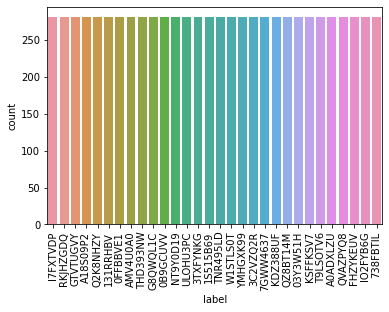

In [52]:
sns.countplot(x='label', data=sele_train)
plt.xticks(rotation=90)
plt.show()

### Get subsequences

For each sequence, take 1 subsequence randomly with random Reverse Translatation

In [53]:
num_subseq_per_seq = 1
seq_len = 2048


random_seq_sele = []

np.random.seed(42)

for seq in sele_train['sequence']:
    sub_list = []
    for _ in range(num_subseq_per_seq):
        # if sequence is shorter, take entire sequence and it will be padded
        # if it has a N on it, this is a problem and would be better to manually analyze and discard this observation before running cell
        if len(seq) <= seq_len:
            if 'N' in seq.upper(): 
                raise ValueError("Can't process sequences, found a sequence shorter than seq_len and with a N character...discard this sequence")
            # with probability 0.5 make the Reverse Complement of that sequence
            if np.random.rand() > .5:
                sub_list.append(seq)
            else:
                sub_list.append(rev_comp(seq))
        else:
            # if sequence is longer, need to randomly select a subsequence
            subseq ='' # initialize to enter while
            # keep looking for subsequences until they do not have any N (this might bias a bit the initial positions)
            while ('N' in subseq.upper()) or (len(subseq) != seq_len):
                start_pos = np.random.randint(len(seq) - seq_len + 1)
                subseq = seq[start_pos:start_pos+seq_len]
            # with probability 0.5 make the Reverse Complement of that sequence
            if np.random.rand() > .5:
                sub_list.append(subseq)
            else:
                sub_list.append(rev_comp(subseq))
    random_seq_sele.append(sub_list)

In [54]:
# 8 subsequences per each sequence
print(f'Expected {len(sele_labs) * obs_per_label * num_subseq_per_seq} sequences')
print('Got:', np.array(random_seq_sele).shape)

Expected 8430 sequences
Got: (8430, 1)


In [55]:
sele_train['random_seq_sele'] = random_seq_sele

there are 88 repeats in this subset, not a problem, it can just happen by random selection and it is not much compared to 8000 total examples


In [56]:
print(sele_train['random_seq_sele'].shape)
print(np.sum(sele_train['random_seq_sele'].value_counts() > 1))

(8430,)
88


Number of repeated sequences divided by class. Not many compared to 283 seqs we have per class

In [57]:
rep_seqs = []
for lab in sele_labs:
    rep_seqs.append(np.sum(sele_train[sele_train['label'] == lab]['random_seq_sele'].value_counts() > 1))

They are repeated in the sample that was short on sequences

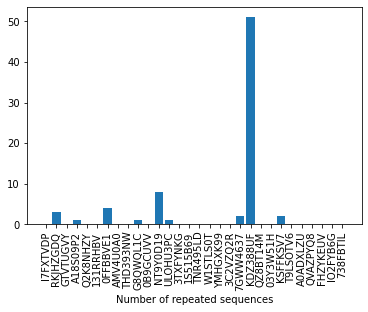

In [58]:
plt.bar(x=sele_labs, height=rep_seqs)
plt.xticks(rotation=90)
plt.xlabel('Number of repeated sequences')
plt.show()

Number of sequences that will require padding

In [59]:
sele_train['sele_seq_len'] = sele_train['random_seq_sele'].apply(lambda x: len(x[0]))

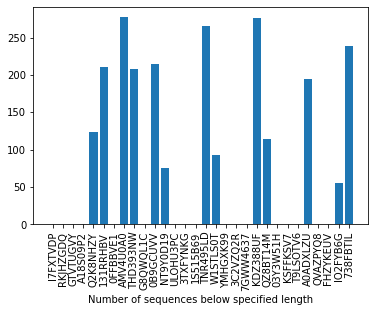

In [60]:
pad_seqs = []
for lab in sele_labs:
    pad_seqs.append(np.sum(sele_train[sele_train['label'] == lab]['sele_seq_len'] < min_len))
plt.bar(x=sele_labs, height=pad_seqs)
plt.xticks(rotation=90)
plt.xlabel('Number of sequences below specified length')
plt.show()

In the labels where sequences need to be padded the mean length (visually) is about 1000, so I guess it is totally fine.

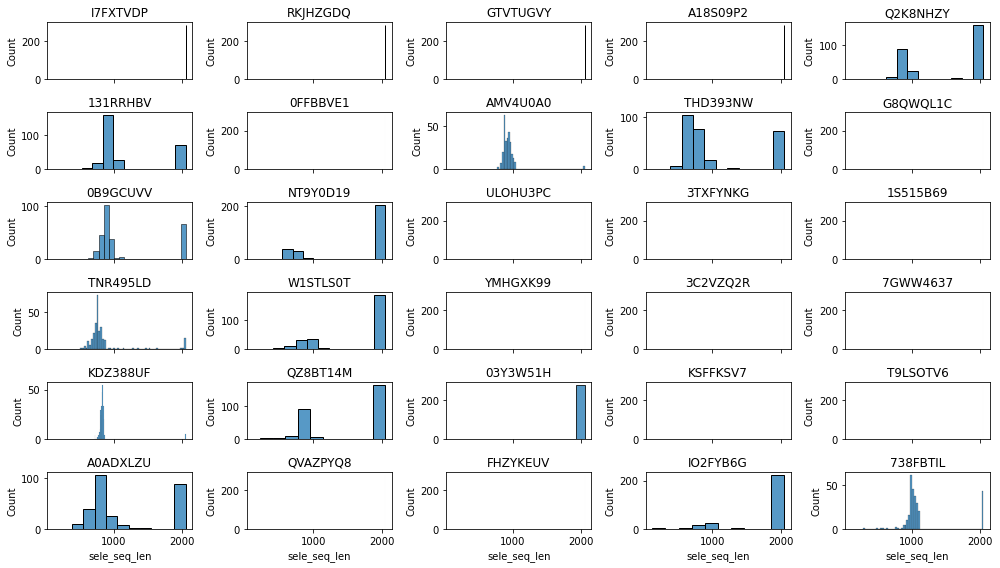

In [61]:
fig, axs = plt.subplots(6,5, figsize=(14,8), sharex=True)
axs = axs.flatten()
for i, lab in enumerate(sele_labs):
    sns.histplot(sele_train[sele_train['label'] == lab]['sele_seq_len'], ax=axs[i])
    axs[i].set_title(lab)
plt.tight_layout()
plt.show()

### Convert labels to integer values

In [62]:
label_key = {}
for i, lab in enumerate(sele_labs):
    label_key[lab] = str(i)

In [63]:
label_key

{'I7FXTVDP': '0',
 'RKJHZGDQ': '1',
 'GTVTUGVY': '2',
 'A18S09P2': '3',
 'Q2K8NHZY': '4',
 '131RRHBV': '5',
 '0FFBBVE1': '6',
 'AMV4U0A0': '7',
 'THD393NW': '8',
 'G8QWQL1C': '9',
 '0B9GCUVV': '10',
 'NT9Y0D19': '11',
 'ULOHU3PC': '12',
 '3TXFYNKG': '13',
 '1S515B69': '14',
 'TNR495LD': '15',
 'W1STLS0T': '16',
 'YMHGXK99': '17',
 '3C2VZQ2R': '18',
 '7GWW4637': '19',
 'KDZ388UF': '20',
 'QZ8BT14M': '21',
 '03Y3W51H': '22',
 'KSFFKSV7': '23',
 'T9LSOTV6': '24',
 'A0ADXLZU': '25',
 'QVAZPYQ8': '26',
 'FHZYKEUV': '27',
 'IO2FYB6G': '28',
 '738FBTIL': '29'}

In [64]:
sele_train['bin_label'] = [label_key[lab] for lab in sele_train['label']]

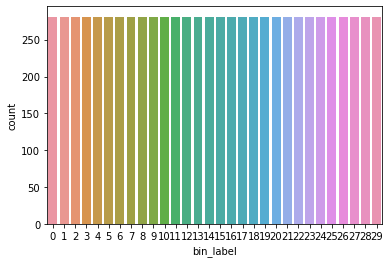

In [65]:
sns.countplot(x='bin_label', data=sele_train)
plt.show()

## Conver to kmers

In [66]:
kmer_size = 6

Use their function seq2kmer from `motif/motif_utils.py`

In [67]:
def seq2kmer(seq, k):
    """
    Convert original sequence to kmers
    
    Arguments:
    seq -- str, original sequence.
    k -- int, kmer of length k specified.
    
    Returns:
    kmers -- str, kmers separated by space

    """
    kmer = [seq[x:x+k] for x in range(len(seq)+1-k)]
    kmers = " ".join(kmer)
    return kmers

Example

In [68]:
sele_train['kmer_rand'] = [[seq2kmer(seq, kmer_size) for seq in subseq] for subseq in sele_train['random_seq_sele']]

In [69]:
sele_train['kmer_rand']

sequence_id
XUE90    [CAAAAC AAAACA AAACAG AACAGC ACAGCC CAGCCA AGC...
D2DC4    [AATTCC ATTCCT TTCCTC TCCTCT CCTCTT CTCTTG TCT...
6LUO6    [GTCTGC TCTGCT CTGCTG TGCTGG GCTGGG CTGGGG TGG...
PPNCE    [TGCGAA GCGAAA CGAAAC GAAACG AAACGA AACGAT ACG...
R1NJC    [CGGTCG GGTCGA GTCGAG TCGAGT CGAGTT GAGTTC AGT...
                               ...                        
UNG0B    [CGGCAA GGCAAT GCAATG CAATGC AATGCC ATGCCG TGC...
38POV    [GCTCTA CTCTAA TCTAAT CTAATG TAATGC AATGCG ATG...
7MDLT    [GCTCTA CTCTAA TCTAAT CTAATG TAATGC AATGCG ATG...
YUPHF    [ATGTAG TGTAGT GTAGTC TAGTCG AGTCGC GTCGCC TCG...
114UP    [TTTTTC TTTTCG TTTCGG TTCGGT TCGGTC CGGTCT GGT...
Name: kmer_rand, Length: 8430, dtype: object

In [70]:
sele_train['kmer_rand'].values[0]

['CAAAAC AAAACA AAACAG AACAGC ACAGCC CAGCCA AGCCAA GCCAAG CCAAGC CAAGCT AAGCTG AGCTGC GCTGCC CTGCCA TGCCAT GCCATT CCATTC CATTCG ATTCGC TTCGCC TCGCCA CGCCAT GCCATT CCATTC CATTCA ATTCAG TTCAGG TCAGGC CAGGCT AGGCTG GGCTGC GCTGCG CTGCGC TGCGCA GCGCAA CGCAAC GCAACT CAACTG AACTGT ACTGTT CTGTTG TGTTGG GTTGGG TTGGGA TGGGAA GGGAAG GGAAGG GAAGGG AAGGGC AGGGCG GGGCGA GGCGAT GCGATC CGATCG GATCGG ATCGGT TCGGTG CGGTGC GGTGCG GTGCGG TGCGGG GCGGGC CGGGCC GGGCCT GGCCTC GCCTCT CCTCTT CTCTTC TCTTCG CTTCGC TTCGCT TCGCTA CGCTAT GCTATT CTATTA TATTAC ATTACG TTACGC TACGCC ACGCCA CGCCAG GCCAGC CCAGCT CAGCTG AGCTGG GCTGGC CTGGCG TGGCGA GGCGAA GCGAAA CGAAAG GAAAGG AAAGGG AAGGGG AGGGGG GGGGGA GGGGAT GGGATG GGATGT GATGTG ATGTGC TGTGCT GTGCTG TGCTGC GCTGCA CTGCAA TGCAAG GCAAGG CAAGGC AAGGCG AGGCGA GGCGAT GCGATT CGATTA GATTAA ATTAAG TTAAGT TAAGTT AAGTTG AGTTGG GTTGGG TTGGGT TGGGTA GGGTAA GGTAAC GTAACG TAACGC AACGCC ACGCCA CGCCAG GCCAGG CCAGGG CAGGGT AGGGTT GGGTTT GGTTTT GTTTTC TTTTCC TTTCCC TTCCCA TCCCAG CCCAGT CCAG

In [71]:
6*(2048-5)+(2048-5)-1 # last kmer does not have end space

14300

In [72]:
len(sele_train['kmer_rand'].values[0][0])

14300

Now, I need to get individual subsequence kmer represnetations as each row, so numbers of rows will grow 8 times more...

In [73]:
final_data = []

for seq_idx, row in sele_train.iterrows():
    bin_label = row['bin_label']
    for seq in row['kmer_rand']:
        final_data.append({
            'sequence_id': seq_idx,
            'sequence': seq,
            'label': bin_label
        })

final_data = pd.DataFrame.from_records(final_data)

In [74]:
final_data.shape

(8430, 3)

In [75]:
final_data.set_index('sequence_id', inplace=True)

In [76]:
final_data

,sequence,label
sequence_id,,
XUE90,CAAAAC AAAACA AAACAG AACAGC ACAGCC CAGCCA AGCC...,0
D2DC4,AATTCC ATTCCT TTCCTC TCCTCT CCTCTT CTCTTG TCTT...,0
6LUO6,GTCTGC TCTGCT CTGCTG TGCTGG GCTGGG CTGGGG TGGG...,0
PPNCE,TGCGAA GCGAAA CGAAAC GAAACG AAACGA AACGAT ACGA...,0
R1NJC,CGGTCG GGTCGA GTCGAG TCGAGT CGAGTT GAGTTC AGTT...,0
...,...,...
UNG0B,CGGCAA GGCAAT GCAATG CAATGC AATGCC ATGCCG TGCC...,29
38POV,GCTCTA CTCTAA TCTAAT CTAATG TAATGC AATGCG ATGC...,29
7MDLT,GCTCTA CTCTAA TCTAAT CTAATG TAATGC AATGCG ATGC...,29


## Split data

Original finetuning data is split between a dev.tsv file with 1000 observations and a train.tsv file with 32367 observations. I think the dev set is used during training to evaluate the accuracy on a held-out dataset (test accuracy). 

**SINCE I AM NOT COMPARING MODELS BETWEEN THEM, BECAUSE THE DATA I USE IN EVERYONE IS DIFFEERENT, THERE IS NO USE FOR A TRAIN DATASET THAT IS NOT USED TO EVALUATE OR CHOOSE HYPERPARAMETERS OF THE MODEL AND IS ONLY USED TO COMPARE ACROSS MODELS, HENCE IT IS FINE TO JUST USE THE DEV SET, WHICH IS NOT USED DURING FINETUNING TO SET ANY KIND OF PARAMETER**

I want a perfectly balanced test set. So I manually subsample each class to about 1000 total sequences (closest multiple to number of classes)

In [77]:
num_dev_class = math.floor(1000/len(sele_labs))

In [78]:
num_dev_class

33

In [79]:
dev_data = final_data.groupby('label').sample(num_dev_class, replace=False, random_state=42).copy()

to get the train_data I need to make a list from 0 to len(train_data) excluding those indices in dev_data

In [80]:
train_data = final_data[~(final_data.index.isin(dev_data.index))].copy()

They are balanced

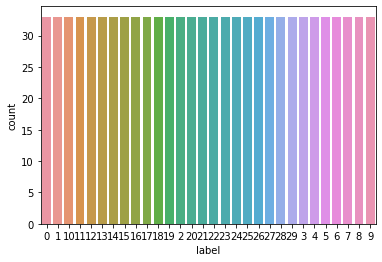

In [81]:
sns.countplot(x='label', data=dev_data)
plt.show()

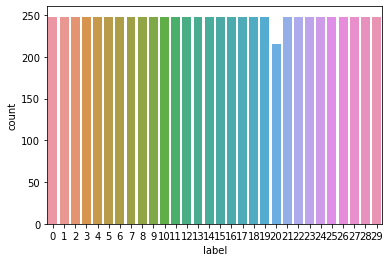

In [82]:
sns.countplot(x='label', data=train_data)
plt.show()

In [83]:
dev_data

,sequence,label
sequence_id,,
G1YXQ,CTCCTC TCCTCT CCTCTG CTCTGA TCTGAG CTGAGT TGAG...,0
4FO8R,TATTGT ATTGTT TTGTTG TGTTGA GTTGAT TTGATG TGAT...,0
VZEJO,ATTTGG TTTGGT TTGGTA TGGTAT GGTATC GTATCT TATC...,0
LQIRL,TGAATG GAATGA AATGAG ATGAGG TGAGGG GAGGGC AGGG...,0
L60FM,AAGAAC AGAACG GAACGG AACGGC ACGGCA CGGCAT GGCA...,0
...,...,...
9QEBJ,AATGAG ATGAGG TGAGGG GAGGGC AGGGCA GGGCAT GGCA...,9
MQXOQ,CTTTTC TTTTCA TTTCAT TTCATA TCATAA CATAAT ATAA...,9
YASRI,AGTTGA GTTGAT TTGATT TGATTT GATTTT ATTTTC TTTT...,9


In [84]:
train_data

,sequence,label
sequence_id,,
XUE90,CAAAAC AAAACA AAACAG AACAGC ACAGCC CAGCCA AGCC...,0
D2DC4,AATTCC ATTCCT TTCCTC TCCTCT CCTCTT CTCTTG TCTT...,0
6LUO6,GTCTGC TCTGCT CTGCTG TGCTGG GCTGGG CTGGGG TGGG...,0
PPNCE,TGCGAA GCGAAA CGAAAC GAAACG AAACGA AACGAT ACGA...,0
R1NJC,CGGTCG GGTCGA GTCGAG TCGAGT CGAGTT GAGTTC AGTT...,0
...,...,...
83HW4,GTAGTG TAGTGG AGTGGC GTGGCC TGGCCG GGCCGC GCCG...,29
UNG0B,CGGCAA GGCAAT GCAATG CAATGC AATGCC ATGCCG TGCC...,29
38POV,GCTCTA CTCTAA TCTAAT CTAATG TAATGC AATGCG ATGC...,29


### Shuffle

As it is now, observations are ordered by label. Will shuffle it just in case the model does not shuffle input data to take the 32 batch sizes (I bet it does)

In [85]:
train_data = train_data.sample(frac=1, random_state=42)

In [86]:
dev_data

,sequence,label
sequence_id,,
G1YXQ,CTCCTC TCCTCT CCTCTG CTCTGA TCTGAG CTGAGT TGAG...,0
4FO8R,TATTGT ATTGTT TTGTTG TGTTGA GTTGAT TTGATG TGAT...,0
VZEJO,ATTTGG TTTGGT TTGGTA TGGTAT GGTATC GTATCT TATC...,0
LQIRL,TGAATG GAATGA AATGAG ATGAGG TGAGGG GAGGGC AGGG...,0
L60FM,AAGAAC AGAACG GAACGG AACGGC ACGGCA CGGCAT GGCA...,0
...,...,...
9QEBJ,AATGAG ATGAGG TGAGGG GAGGGC AGGGCA GGGCAT GGCA...,9
MQXOQ,CTTTTC TTTTCA TTTCAT TTCATA TCATAA CATAAT ATAA...,9
YASRI,AGTTGA GTTGAT TTGATT TGATTT GATTTT ATTTTC TTTT...,9


In [87]:
dev_data = dev_data.sample(frac=1, random_state=42)

In [88]:
dev_data

,sequence,label
sequence_id,,
WYPTY,TTGTAA TGTAAT GTAATA TAATAC AATACT ATACTG TACT...,14
ITHK9,CGGTGC GGTGCG GTGCGG TGCGGG GCGGGC CGGGCC GGGC...,18
AFL9H,ATCAAT TCAATA CAATAA AATAAG ATAAGT TAAGTC AAGT...,22
D3NZ7,GTCTTT TCTTTT CTTTTA TTTTAC TTTACA TTACAT TACA...,17
7EFF3,TTACAA TACAAC ACAACA CAACAA AACAAC ACAACA CAAC...,10
...,...,...
N7YD7,TGCTCA GCTCAC CTCACG TCACGC CACGCT ACGCTG CGCT...,11
C7ERM,AGAGAG GAGAGA AGAGAT GAGATA AGATAA GATAAT ATAA...,16
OE107,AGACTC GACTCC ACTCCC CTCCCT TCCCTG CCCTGT CCTG...,6


### Export

Finally, export this dataframes in the appropriate format and in a .csv file that could be read back to pandas (which contains information about the indices!)

In [89]:
train_data.to_csv(f'{path_prefix}/transformers/6_gea30xl/in_data/train_data.csv')
dev_data.to_csv(f'{path_prefix}/transformers/6_gea30xl/in_data/dev_data.csv')

Model will use these tsv files.

In [90]:
train_data.to_csv(f'{path_prefix}/transformers/6_gea30xl/in_data/train.tsv', sep='\t', index=False)
dev_data.to_csv(f'{path_prefix}/transformers/6_gea30xl/in_data/dev.tsv', sep='\t', index=False)